## Configuration Spark

In [1]:
import socket

def check_port(host, port):
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    sock.settimeout(5)  # Timeout de 5 secondes
    result = sock.connect_ex((host, port))
    if result == 0:
        print(f"Connexion réussie à {host}:{port}")
    else:
        print(f"Impossible de se connecter à {host}:{port}")
    sock.close()

check_port("kafka1", 9092)


Connexion réussie à kafka1:9092


In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

conf = SparkConf() \
    .setAppName('SparkApp') \
    .setMaster('spark://spark:7077') \
    .set("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4,org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.3") \
    .set("spark.sql.shuffle.partitions", "10")
 

sc = SparkContext.getOrCreate(conf=conf)


# Créer un SQLContext pour les opérations SQL
sql_context = SQLContext(sc)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7848d4e8-b9ab-46bb-89f6-dbe2085da980;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.3 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.3 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	

## Imports

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col, count, window, avg, to_timestamp, min, max, last, broadcast, current_timestamp
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType, DoubleType, BooleanType
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Schémas et Topics


In [4]:
kafka_broker = "kafka1:9092"
arrets_topic = "arrets"
velos_topic = "velos"
relais_topic = "relais"

# Définition du schéma pour le topic "arrets"
schema_arrets = StructType([
    StructField("codeLieu", StringType()),
    StructField("libelle", StringType()),
    StructField("distance", FloatType()),
    StructField("ligne", StringType())
])

# Définition du schéma pour le champ "position"
position_schema = StructType([
    StructField("lon", DoubleType()),
    StructField("lat", DoubleType())
])

# Définition du schéma pour le topic "velos"
schema_velos = StructType([
    StructField("number", StringType()),
    StructField("name", StringType()),
    StructField("address", StringType()),
    StructField("position", position_schema),
    StructField("banking", StringType()),
    StructField("bonus", StringType()),
    StructField("status", StringType()),
    StructField("contract_name", StringType()),
    StructField("bike_stands", IntegerType()),
    StructField("available_bike_stands", IntegerType()),
    StructField("available_bikes", IntegerType()),
    StructField("last_update", StringType())
])

# Définition du schéma pour le topic "relais"
schema_relais = StructType([
    StructField("grp_identifiant", StringType()),
    StructField("grp_nom", StringType()),
    StructField("grp_statut", IntegerType()),
    StructField("grp_disponible", IntegerType()),
    StructField("grp_exploitation", IntegerType()),
    StructField("grp_complet", IntegerType()),
    StructField("grp_horodatage", StringType()),
    StructField("idobj", StringType()),
    StructField("location", StructType([
        StructField("lon", DoubleType()),
        StructField("lat", DoubleType())
    ])),
    StructField("disponibilite", DoubleType())
])


## Requête Batch sans fenêtre

Comptage des arrêts par ligne à partir du topic « arrets »

In [ ]:
# Lecture brute des messages Kafka
df_kafka = sql_context.read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", arrets_topic) \
    .option("startingOffsets", "earliest") \
    .load()

# Conversion du champ "value" (encodé en JSON) en colonnes structurées
df_arrets = df_kafka.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema_arrets).alias("data")) \
    .select("data.*")

# Agrégation : compter le nombre d'arrêts par "ligne"
result = df_arrets.groupBy("ligne").agg(count("*").alias("nb_arrets"))

# Affichage du résultat
result.show()
result.describe().show()

## Requête Batch avec fenêtre

Vélos disponibles par contrat sur des fenêtres temporelles à partir du topic « velos ».
Malheuresement on a qu'une donnée par station donc ca permet pas de faire de l'aggrégation comme la moyenne de vélo sur la période..... faut essayer de trouver des données plus pertinentes.

In [ ]:
# Lecture brute des messages Kafka
df_kafka = sql_context.read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", velos_topic) \
    .option("startingOffsets", "earliest") \
    .load()

# Conversion du champ "value" en JSON
df_velos = df_kafka.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema_velos).alias("data")) \
    .select("data.*")

# Conversion de "last_update" en timestamp (format ISO 8601)
df_velos = df_velos.withColumn("last_update_ts", 
                               to_timestamp(col("last_update"), "yyyy-MM-dd'T'HH:mm:ssXXX"))

# Agrégation par fenêtre (ici, on allonge la fenêtre à 30 minutes pour accumuler plusieurs mises à jour) et par station
result_window = df_velos.groupBy(
    window(col("last_update_ts"), "30 minutes"), 
    col("number"),
    col("contract_name")
).agg(
    count("*").alias("nb_updates"),
    last("available_bikes", ignorenulls=True).alias("latest_available_bikes")
)

result_window.show()

### Batch et visualisation graphique

25/02/17 12:56:28 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


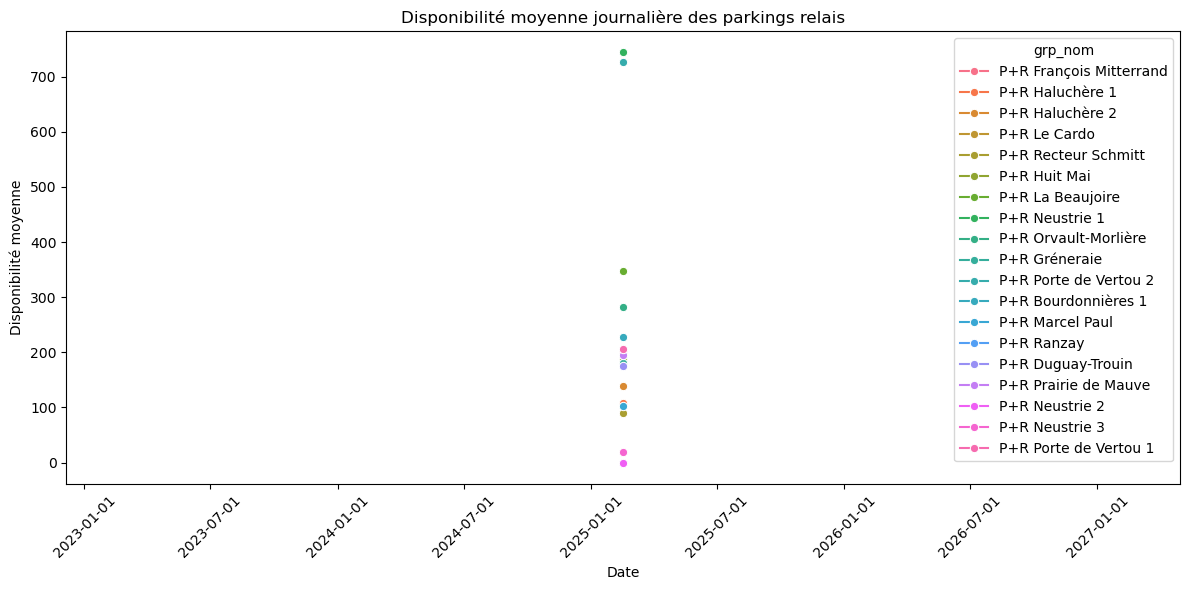

In [ ]:
# Lecture batch depuis Kafka
df_kafka = sql_context.read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", relais_topic) \
    .option("startingOffsets", "earliest") \
    .load()

# Conversion du JSON
df_relais = df_kafka.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema_relais).alias("data")) \
    .select("data.*")

# Conversion du champ de date en timestamp (format ISO 8601)
df_relais = df_relais.withColumn("horodatage_ts", 
                                  to_timestamp(col("grp_horodatage"), "yyyy-MM-dd'T'HH:mm:ssXXX"))

# Agrégation : calcul de la disponibilité moyenne par parking sur une fenêtre d'1 jour
result = df_relais.groupBy(
    window(col("horodatage_ts"), "1 hour"),
    col("grp_identifiant"),
    col("grp_nom")
).agg(
    avg("disponibilite").alias("avg_disponibilite")
)

# Extraire la date de début de la fenêtre pour le graphique
result = result.withColumn("window_start", col("window.start")).drop("window")

# Conversion du résultat en DataFrame Pandas
pandas_df = result.toPandas()

# Tri des données par date et par parking
pandas_df.sort_values(by=["window_start", "grp_identifiant"], inplace=True)

# Visualisation avec Seaborn : une ligne par parking (grp_nom)
plt.figure(figsize=(12, 6))
sns.lineplot(data=pandas_df, x="window_start", y="avg_disponibilite", hue="grp_nom", marker="o")
plt.title("Disponibilité moyenne journalière des parkings relais")
plt.xlabel("Date")
plt.ylabel("Disponibilité moyenne")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Requêtes Streaming

### Récuperer la moyenne des disponiblités des parkings relais sur une fenêtre glissante.

In [ ]:
# Lecture en streaming depuis Kafka
df_kafka = sql_context.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", relais_topic) \
    .option("startingOffsets", "latest") \
    .load()

# Conversion du champ "value" (JSON) en colonnes structurées
df_relais = df_kafka.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema_relais).alias("data")) \
    .select("data.*")

# Conversion du champ "grp_horodatage" en timestamp
# Le format ISO 8601 est utilisé : "yyyy-MM-dd'T'HH:mm:ssXXX"
df_relais = df_relais.withColumn("horodatage_ts", 
                                  to_timestamp(col("grp_horodatage"), "yyyy-MM-dd'T'HH:mm:ssXXX"))

# Définition d'un watermark de 5 minutes pour gérer les retards éventuels
df_relais = df_relais.withWatermark("horodatage_ts", "5 minutes")

# Agrégation : calcul de la moyenne des disponibilités sur une fenêtre glissante
# Ici, la fenêtre est de 5 minutes et on agrège par "grp_identifiant"
result_stream = df_relais.groupBy(
    window(col("horodatage_ts"), "5 minutes"),
    col("grp_identifiant"),
).agg(
    avg("disponibilite").alias("avg_disponibilite")
)

# Écriture du résultat en streaming vers la console (mode "update")
query = result_stream.writeStream \
    .outputMode("update") \
    .format("console") \
    .option("truncate", "false") \
    .start()

query.awaitTermination()

In [ ]:
query.stop()

### Récuperer la moyenne des vélos disponibles par parking sur une fenêtre glissante.

In [5]:
# Lecture en streaming depuis Kafka
df_kafka_velos = sql_context.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", velos_topic) \
    .option("startingOffsets", "latest") \
    .load()

# Conversion du champ "value" (JSON) en colonnes structurées
df_velos = df_kafka_velos.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema_velos).alias("data")) \
    .select("data.*")

# Conversion du champ "last_update" en timestamp (format ISO 8601)
df_velos = df_velos.withColumn("last_update_ts", 
                               to_timestamp(col("last_update"), "yyyy-MM-dd'T'HH:mm:ssXXX"))

# Application d'un watermark de 5 minutes pour gérer les retards
df_velos = df_velos.withWatermark("last_update_ts", "5 minutes")

# Agrégation sur une fenêtre de 5 minutes : calcul du total des places disponibles
result_velos = df_velos.groupBy(
    window(col("last_update_ts"), "5 minutes"),
    col("name")
).agg(
    avg("available_bikes").alias("moyenne_velos_disponibles")
)

# Écriture du résultat en streaming vers la console (mode "update")
query_velos = result_velos.writeStream \
    .outputMode("update") \
    .format("console") \
    .option("truncate", "false") \
    .start()

query_velos.awaitTermination()

25/02/16 19:06:16 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-d8ffd7e7-3c58-4e7f-af15-b15f21c32c6c. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/02/16 19:06:16 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/02/16 19:06:17 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 0
-------------------------------------------
+------+----+-------------------------+
|window|name|moyenne_velos_disponibles|
+------+----+-------------------------+
+------+----+-------------------------+



-------------------------------------------
Batch: 1
-------------------------------------------
+------------------------------------------+----------------------+-------------------------+
|window                                    |name                  |moyenne_velos_disponibles|
+------------------------------------------+----------------------+-------------------------+
|{2025-02-16 18:55:00, 2025-02-16 19:00:00}|114-ATOUTSUD          |8.0                      |
|{2025-02-16 19:00:00, 2025-02-16 19:05:00}|075-LAMORICIÈRE       |9.0                      |
|{2025-02-16 19:00:00, 2025-02-16 19:05:00}|080-VICTOR HUGO       |10.0                     |
|{2025-02-16 19:05:00, 2025-02-16 19:10:00}|002-HÔTEL DE VILLE    |1.0                      |
|{2024-09-10 05:20:00, 2024-09-10 05:25:00}|069-MANUFACTURE       |0.0                      |
|{2024-09-10 10:00:00, 2024-09-10 10:05:00}|122-MITRIE            |0.0                      |
|{2025-02-16 19:05:00, 2025-02-16 19:10:00}|074-CANCLAUX 

-------------------------------------------
Batch: 2
-------------------------------------------
+------+----+-------------------------+
|window|name|moyenne_velos_disponibles|
+------+----+-------------------------+
+------+----+-------------------------+



-------------------------------------------
Batch: 3
-------------------------------------------
+------------------------------------------+-------------------------+-------------------------+
|window                                    |name                     |moyenne_velos_disponibles|
+------------------------------------------+-------------------------+-------------------------+
|{2025-02-16 19:00:00, 2025-02-16 19:05:00}|075-LAMORICIÈRE          |9.0                      |
|{2025-02-16 19:00:00, 2025-02-16 19:05:00}|080-VICTOR HUGO          |10.0                     |
|{2025-02-16 19:05:00, 2025-02-16 19:10:00}|103-GRUE JAUNE           |3.0                      |
|{2025-02-16 19:05:00, 2025-02-16 19:10:00}|002-HÔTEL DE VILLE       |1.0                      |
|{2025-02-16 19:05:00, 2025-02-16 19:10:00}|074-CANCLAUX             |15.0                     |
|{2025-02-16 19:00:00, 2025-02-16 19:05:00}|070-GARE DE NANTES SUD   |39.0                     |
|{2025-02-16 19:05:00, 2025-02

-------------------------------------------
Batch: 4
-------------------------------------------
+------------------------------------------+---------------------+-------------------------+
|window                                    |name                 |moyenne_velos_disponibles|
+------------------------------------------+---------------------+-------------------------+
|{2025-02-16 19:05:00, 2025-02-16 19:10:00}|006-PLACE DU CIRQUE  |4.0                      |
|{2025-02-16 19:00:00, 2025-02-16 19:05:00}|119-ZOLA             |20.0                     |
|{2025-02-16 19:00:00, 2025-02-16 19:05:00}|100-GRÉNERAIE        |16.0                     |
|{2025-02-16 19:00:00, 2025-02-16 19:05:00}|126-GARE DE CHANTENAY|5.0                      |
|{2025-02-16 19:00:00, 2025-02-16 19:05:00}|045-PRAIRIE AU DUC   |8.0                      |
|{2025-02-16 19:00:00, 2025-02-16 19:05:00}|030-COMMERCE         |29.0                     |
|{2025-02-16 19:05:00, 2025-02-16 19:10:00}|082-SÉBILLEAU        |

-------------------------------------------
Batch: 5
-------------------------------------------
+------------------------------------------+----------+-------------------------+
|window                                    |name      |moyenne_velos_disponibles|
+------------------------------------------+----------+-------------------------+
|{2025-02-16 19:00:00, 2025-02-16 19:05:00}|031-BOURSE|8.0                      |
+------------------------------------------+----------+-------------------------+



-------------------------------------------
Batch: 6
-------------------------------------------
+------------------------------------------+----------------------+-------------------------+
|window                                    |name                  |moyenne_velos_disponibles|
+------------------------------------------+----------------------+-------------------------+
|{2025-02-16 19:00:00, 2025-02-16 19:05:00}|080-VICTOR HUGO       |10.0                     |
|{2025-02-16 19:05:00, 2025-02-16 19:10:00}|002-HÔTEL DE VILLE    |1.0                      |
|{2025-02-16 19:05:00, 2025-02-16 19:10:00}|103-GRUE JAUNE        |3.0                      |
|{2025-02-16 19:00:00, 2025-02-16 19:05:00}|075-LAMORICIÈRE       |9.0                      |
|{2025-02-16 19:05:00, 2025-02-16 19:10:00}|006-PLACE DU CIRQUE   |4.0                      |
|{2025-02-16 19:05:00, 2025-02-16 19:10:00}|074-CANCLAUX          |15.0                     |
|{2025-02-16 19:05:00, 2025-02-16 19:10:00}|095-MICHELET 

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [6]:
query_velos.stop()